In [1]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

import sys
sys.path.insert(0, '..')

from MES_LSTM.model import *
from utils.metrics import *

import warnings
warnings.simplefilter('ignore')

# check version
print(tf.keras.__version__)
print(tf.__version__)
print(tfp.__version__)
print(len(tf.config.experimental.list_physical_devices('GPU')))



2.4.0
2.4.1
0.12.2
0


In [2]:
pre_layer = preprocess(first_time = 0) # change first time to 1 if first time running to download data
df = pre_layer.load_data()
df = pre_layer.clean_data(df)
df = pre_layer.fill_missing(df)
scaled_df, df_scaler = pre_layer.scale(df)
scaled_df

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] data cleaned
[INFO] the dataframe has 30 columns in total and 17 columns that have missing values.
                                      Missing Values  % of Total Values
weekly_icu_admissions                            606              100.0
handwashing_facilities                           606              100.0
total_boosters                                   606              100.0
weekly_hosp_admissions                           528               87.1
excess_mortality                                 521               86.0
excess_mortality_cumulative                      521               86.0
excess_mortality_cumulative_absolute             521               86.0
people_fully_vaccinated                          348               57.4
people_vaccinated                                344               56.8
total_vaccinations                               344               56.8
positive_rate                                     72               11.9
icu_patients                  

,total_cases,total_deaths,reproduction_rate,icu_patients,hosp_patients,total_tests,positive_rate,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,life_expectancy,human_development_index
2020-01-31,1.000000,1.219388,1.562053,1.230915,1.222892,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2020-02-01,1.000000,1.219388,1.562053,1.230915,1.222892,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2020-02-02,1.000000,1.219588,1.548013,1.229693,1.221671,1.000224,1.015909,1.034911,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2020-02-03,1.000001,1.219588,1.548013,1.229693,1.221671,1.000225,1.015908,1.034911,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2020-02-04,1.000001,1.219588,1.548013,1.229693,1.221671,1.000225,1.015908,1.034911,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-23,1.982380,1.996976,1.260890,1.213094,1.165108,2.000000,1.416308,1.412784,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-09-24,1.986996,1.998294,1.274624,1.507074,1.425839,1.930573,1.438995,1.412784,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-09-25,1.990870,1.999238,1.232190,1.499483,1.417557,1.937963,1.490853,1.517195,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-09-26,1.995143,1.999707,1.233444,1.502646,1.420057,1.943145,1.493998,1.514042,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [3]:
mes_layer = ES()
params, internals = mes_layer.es(scaled_df)
es_scaled, df_trend, df_seas = mes_layer.deTS(scaled_df, internals)

es_scaled

[INFO] internals executed


,total_cases,total_deaths,reproduction_rate,icu_patients,hosp_patients,total_tests,positive_rate,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,life_expectancy,human_development_index
2020-01-31,-7.271845e-07,7.848167e-13,-2.917111e-13,-0.000042,8.997161e-13,1.386093e-05,3.613776e-14,-3.430589e-14,7.294544e-10,7.294544e-10,7.294544e-10,7.294544e-10,7.294544e-10,7.294544e-10,7.294544e-10,7.294544e-10,7.294544e-10,7.294544e-10,7.294544e-10,7.294544e-10
2020-02-01,7.012031e-07,1.856826e-11,8.561485e-13,0.000122,2.573511e-11,8.541193e-07,-6.323830e-13,-1.970979e-12,1.455251e-09,1.455251e-09,1.455251e-09,1.455251e-09,1.455251e-09,1.455251e-09,1.455251e-09,1.455251e-09,1.455251e-09,1.455251e-09,1.455251e-09,1.455251e-09
2020-02-02,4.943612e-07,3.137662e-11,-1.295981e-10,-0.000064,-4.969334e-11,-5.523440e-05,2.695011e-12,9.606427e-12,2.177418e-09,2.177418e-09,2.177418e-09,2.177418e-09,2.177418e-09,2.177418e-09,2.177418e-09,2.177418e-09,2.177418e-09,2.177418e-09,2.177418e-09,2.177418e-09
2020-02-03,1.262592e-07,2.816608e-11,1.284605e-10,-0.000102,-5.453803e-11,-9.117625e-05,-6.866174e-13,-2.718714e-12,2.895973e-09,2.895973e-09,2.895973e-09,2.895973e-09,2.895973e-09,2.895973e-09,2.895973e-09,2.895973e-09,2.895973e-09,2.895973e-09,2.895973e-09,2.895973e-09
2020-02-04,3.767956e-08,7.129075e-12,-5.030143e-12,0.000051,2.940360e-11,9.491688e-05,-9.302004e-13,-3.351652e-12,3.610934e-09,3.610934e-09,3.610934e-09,3.610934e-09,3.610934e-09,3.610934e-09,3.610934e-09,3.610934e-09,3.610934e-09,3.610934e-09,3.610934e-09,3.610934e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-23,1.030250e-06,2.201572e-13,3.992168e-11,-0.000022,-2.260188e-11,1.909155e-02,3.068612e-11,4.501954e-13,1.347851e-07,1.347851e-07,1.347851e-07,1.347851e-07,1.347851e-07,1.347851e-07,1.347851e-07,1.347851e-07,1.347851e-07,1.347851e-07,1.347851e-07,1.347851e-07
2021-09-24,1.783162e-07,3.538342e-11,-1.790189e-10,0.022149,3.156926e-09,-1.109232e-02,1.909473e-12,2.453593e-14,1.348090e-07,1.348090e-07,1.348090e-07,1.348090e-07,1.348090e-07,1.348090e-07,1.348090e-07,1.348090e-07,1.348090e-07,1.348090e-07,1.348090e-07,1.348090e-07
2021-09-25,-2.951424e-06,-5.958734e-12,-4.981710e-10,-0.002746,-4.633893e-10,-1.316005e-03,8.148315e-12,3.438749e-11,1.348327e-07,1.348327e-07,1.348327e-07,1.348327e-07,1.348327e-07,1.348327e-07,1.348327e-07,1.348327e-07,1.348327e-07,1.348327e-07,1.348327e-07,1.348327e-07
2021-09-26,1.877356e-06,-1.801781e-12,3.887672e-10,-0.003375,-3.304705e-10,1.328380e-04,-2.474410e-12,-8.881451e-12,1.348562e-07,1.348562e-07,1.348562e-07,1.348562e-07,1.348562e-07,1.348562e-07,1.348562e-07,1.348562e-07,1.348562e-07,1.348562e-07,1.348562e-07,1.348562e-07


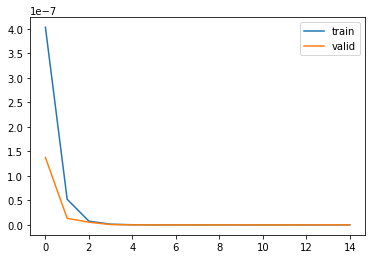

In [4]:
dl_layer = lstm()
train, valid, test, x_train, y_train, x_valid, y_valid, x_test = dl_layer.split(es_scaled)
y_pred_es_scaled = dl_layer.forecast_model(test, x_train, y_train, x_valid, y_valid, x_test)

[INFO] forecasts saved in results folder


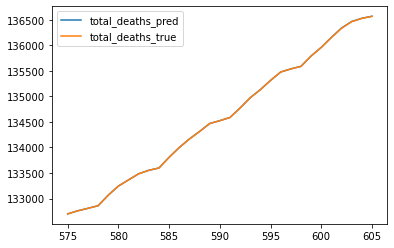

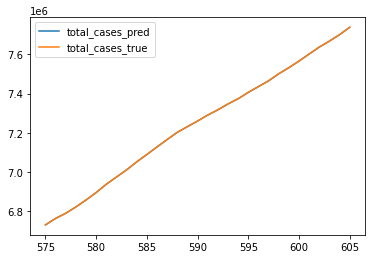

In [5]:
forecasts = dl_layer.reTS(y_pred_es_scaled, es_scaled, train, valid, df_trend, df_seas, df_scaler, df)

### prediction intervals

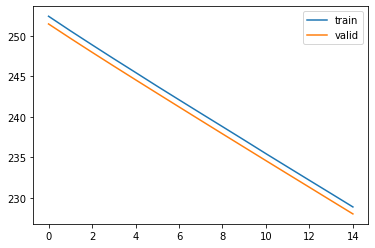

[INFO] prediction intervals computed


In [6]:
pi_pred_es_scaled = dl_layer.pi_model(test, x_train, y_train, x_valid, y_valid, x_test)

[INFO] prediction intervals saved in results folder


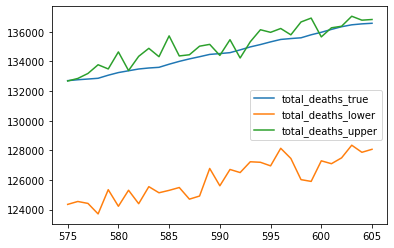

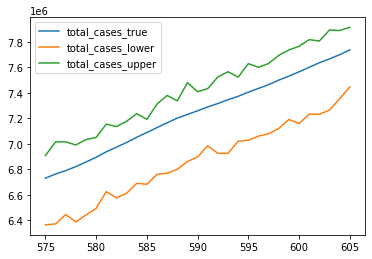

In [7]:
pi = dl_layer.reTS_pi(pi_pred_es_scaled, es_scaled, train, valid, df_trend, df_seas, df_scaler, df)

In [8]:
# print('\n' + 'MIS for MES-RNN:\n', file = f)
print(mis(pi['total_deaths_lower'].values, pi['total_deaths_upper'].values, pi['total_deaths_true'].values, alpha = dl_layer.alpha))
print(mis(pi['total_cases_lower'].values, pi['total_cases_upper'].values, pi['total_cases_true'].values, alpha = dl_layer.alpha))

9684.826710205412
563896.8129696485


In [9]:
# print('\n' + 'MIS for MES-RNN:\n', file = f)
print(coverage(pi['total_deaths_lower'].values, pi['total_deaths_upper'].values, pi['total_deaths_true'].values))
print(coverage(pi['total_cases_lower'].values, pi['total_cases_upper'].values, pi['total_cases_true'].values))

87.09677419354838
100.0


In [10]:
print(smape(forecasts['total_deaths_true'], forecasts['total_deaths_pred']))
print(smape(forecasts['total_cases_true'], forecasts['total_cases_pred']))

0.0008752953297348999
0.0017247931395767834


In [11]:
print(rmse(forecasts['total_deaths_true'], forecasts['total_deaths_pred']))
print(rmse(forecasts['total_cases_true'], forecasts['total_cases_pred']))

1.5456504083257678
138.19515220628378


# RNN

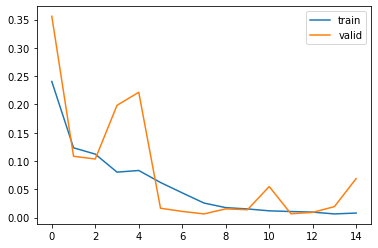

[INFO] forecasts saved in results folder


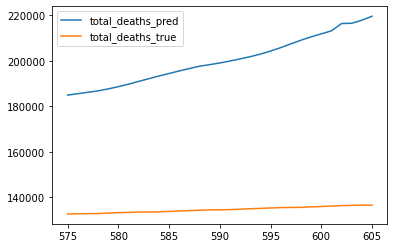

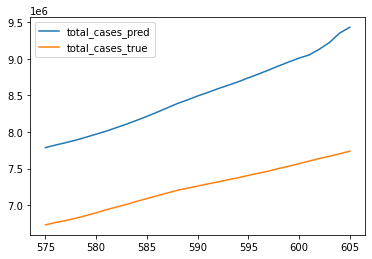

In [12]:
dl_layer = lstm(results_path = 'results/pure_lstm/')
train, valid, test, x_train, y_train, x_valid, y_valid, x_test = dl_layer.split(scaled_df)
y_pred_scaled = dl_layer.forecast_model(test, x_train, y_train, x_valid, y_valid, x_test)

forecasts = dl_layer.descale(y_pred_scaled, scaled_df, train, valid, df_scaler, df)

### prediction intervals

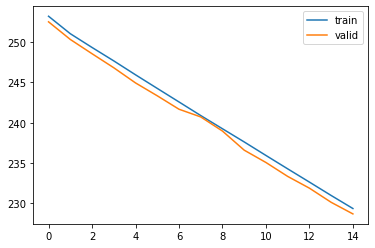

[INFO] prediction intervals computed
[INFO] prediction intervals saved in results folder


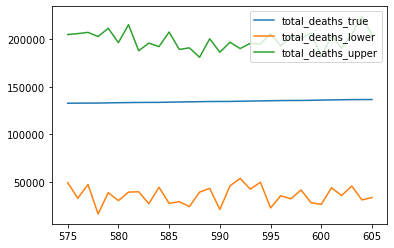

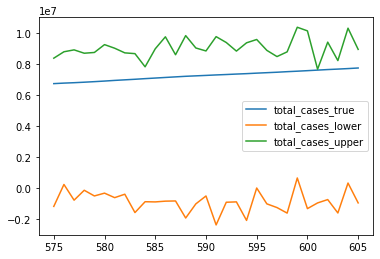

In [13]:
pi_pred_scaled = dl_layer.pi_model(test, x_train, y_train, x_valid, y_valid, x_test)

pi = dl_layer.descale_pi(pi_pred_scaled, scaled_df, train, valid, df_scaler, df)

In [14]:
pi.head()

,total_deaths_true,total_deaths_lower,total_cases_lower,total_cases_true,total_deaths_upper,total_cases_upper
575,132699.0,49468.181676,-1.191223e+06,6729912.0,204693.521041,8.371751e+06
576,132760.0,33157.653849,2.241547e+05,6762904.0,205638.316534,8.785019e+06
577,132808.0,47505.661208,-7.894370e+05,6789189.0,206926.545558,8.906846e+06
578,132859.0,16729.599445,-1.504162e+05,6821356.0,202524.099909,8.691004e+06
579,133066.0,39039.902218,-5.172874e+05,6856933.0,211181.330027,8.739875e+06


In [15]:
# print('\n' + 'MIS for MES-RNN:\n', file = f)
print(mis(pi['total_deaths_lower'].values, pi['total_deaths_upper'].values, pi['total_deaths_true'].values, alpha = dl_layer.alpha))
print(mis(pi['total_cases_lower'].values, pi['total_cases_upper'].values, pi['total_cases_true'].values, alpha = dl_layer.alpha))

162547.11317098685
9912477.616148982


In [16]:
# print('\n' + 'MIS for MES-RNN:\n', file = f)
print(coverage(pi['total_deaths_lower'].values, pi['total_deaths_upper'].values, pi['total_deaths_true'].values))
print(coverage(pi['total_cases_lower'].values, pi['total_cases_upper'].values, pi['total_cases_true'].values))

100.0
100.0


In [17]:
print(smape(forecasts['total_deaths_true'], forecasts['total_deaths_pred']))
print(smape(forecasts['total_cases_true'], forecasts['total_cases_pred']))

39.06597739847411
15.949089948007126


In [ ]:
print(rmse(forecasts['total_deaths_true'], forecasts['total_deaths_pred']))
print(rmse(forecasts['total_cases_true'], forecasts['total_cases_pred']))

# VARMAX

In [ ]:
bench = stats()
train, test, x_train, x_test = bench.split(scaled_df)
y_pred_scaled, pi_pred_scaled = bench.forecast_varmax(test, x_train, y_train, x_test)
forecasts = bench.descale(y_pred_scaled, scaled_df, train, valid, df_scaler, df)
pi = bench.descale_pi(pi_pred_scaled, scaled_df, train, valid, df_scaler, df)

In [20]:
# print('\n' + 'MIS for MES-RNN:\n', file = f)
print(mis(pi['total_deaths_lower'].values, pi['total_deaths_upper'].values, pi['total_deaths_true'].values, alpha = dl_layer.alpha))
print(mis(pi['total_cases_lower'].values, pi['total_cases_upper'].values, pi['total_cases_true'].values, alpha = dl_layer.alpha))

811747.1159148748
5801912.116551649


In [21]:
# print('\n' + 'MIS for MES-RNN:\n', file = f)
print(coverage(pi['total_deaths_lower'].values, pi['total_deaths_upper'].values, pi['total_deaths_true'].values))
print(coverage(pi['total_cases_lower'].values, pi['total_cases_upper'].values, pi['total_cases_true'].values))

0.0
0.0


In [22]:
print(smape(forecasts['total_deaths_true'], forecasts['total_deaths_pred']))
print(smape(forecasts['total_cases_true'], forecasts['total_cases_pred']))

29.345439297324944
5.770657203633001


In [23]:
print(rmse(forecasts['total_deaths_true'], forecasts['total_deaths_pred']))
print(rmse(forecasts['total_cases_true'], forecasts['total_cases_pred']))

47176.49997739965
434857.0543308304


# SARIMAX

[INFO] SARIMAX fitting complete
[INFO] forecasts saved in results folder
[INFO] prediction intervals saved in results folder


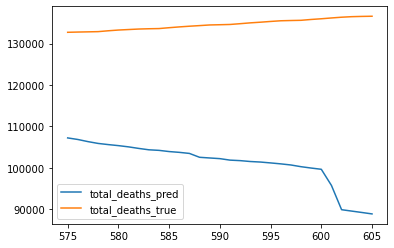

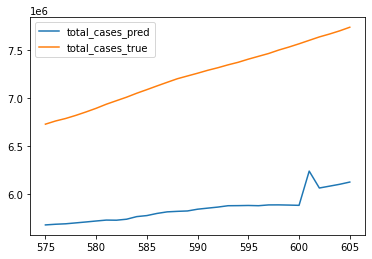

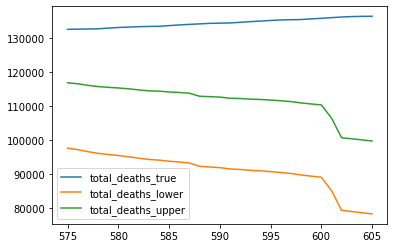

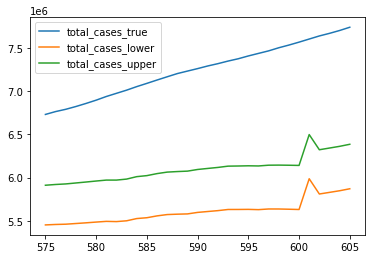

In [24]:
bench = stats(results_path = 'results/sarimax/')
# train, test, x_train, x_test = bench.split(scaled_df)
y_pred_scaled, pi_pred_scaled = bench.forecast_sarimax(test, x_train, y_train, x_test)
forecasts = bench.descale(y_pred_scaled, scaled_df, train, valid, df_scaler, df)
pi = bench.descale_pi(pi_pred_scaled, scaled_df, train, valid, df_scaler, df)

In [25]:
# print('\n' + 'MIS for MES-RNN:\n', file = f)
print(mis(pi['total_deaths_lower'].values, pi['total_deaths_upper'].values, pi['total_deaths_true'].values, alpha = dl_layer.alpha))
print(mis(pi['total_cases_lower'].values, pi['total_cases_upper'].values, pi['total_cases_true'].values, alpha = dl_layer.alpha))

481033.8318416204
23290830.365714513


In [26]:
# print('\n' + 'MIS for MES-RNN:\n', file = f)
print(coverage(pi['total_deaths_lower'].values, pi['total_deaths_upper'].values, pi['total_deaths_true'].values))
print(coverage(pi['total_cases_lower'].values, pi['total_cases_upper'].values, pi['total_cases_true'].values))

0.0
0.0


In [27]:
print(smape(forecasts['total_deaths_true'], forecasts['total_deaths_pred']))
print(smape(forecasts['total_cases_true'], forecasts['total_cases_pred']))

28.403241133807054
21.1116954244153


In [28]:
print(rmse(forecasts['total_deaths_true'], forecasts['total_deaths_pred']))
print(rmse(forecasts['total_cases_true'], forecasts['total_cases_pred']))

33946.79241488683
1398362.4059241407


# MLR

[INFO] MLR fitting complete
[INFO] forecasts saved in results folder
[INFO] prediction intervals saved in results folder


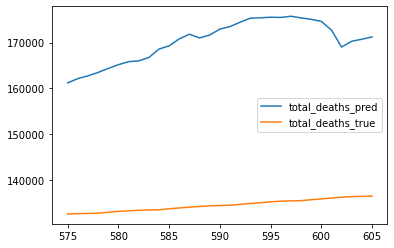

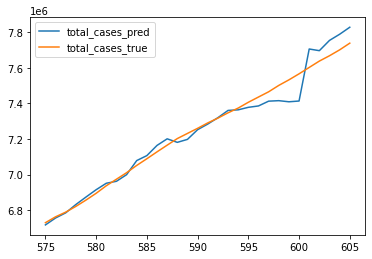

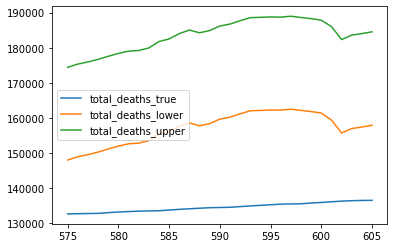

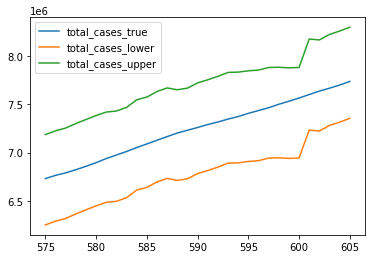

In [29]:
bench = stats(results_path = 'results/mlr/')
# train, test, x_train, x_test = bench.split(scaled_df)
y_pred_scaled, pi_pred_scaled = bench.forecast_mlr(test, x_train, y_train, x_test)
forecasts = bench.descale(y_pred_scaled, scaled_df, train, valid, df_scaler, df)
pi = bench.descale_pi(pi_pred_scaled, scaled_df, train, valid, df_scaler, df)

In [30]:
# print('\n' + 'MIS for MES-RNN:\n', file = f)
print(mis(pi['total_deaths_lower'].values, pi['total_deaths_upper'].values, pi['total_deaths_true'].values, alpha = dl_layer.alpha))
print(mis(pi['total_cases_lower'].values, pi['total_cases_upper'].values, pi['total_cases_true'].values, alpha = dl_layer.alpha))

475603.5747955874
940111.3790147128


In [31]:
# print('\n' + 'MIS for MES-RNN:\n', file = f)
print(coverage(pi['total_deaths_lower'].values, pi['total_deaths_upper'].values, pi['total_deaths_true'].values))
print(coverage(pi['total_cases_lower'].values, pi['total_cases_upper'].values, pi['total_cases_true'].values))

0.0
100.0


In [32]:
print(smape(forecasts['total_deaths_true'], forecasts['total_deaths_pred']))
print(smape(forecasts['total_cases_true'], forecasts['total_cases_pred']))

23.37952457860415
0.5359928768306789


In [33]:
print(rmse(forecasts['total_deaths_true'], forecasts['total_deaths_pred']))
print(rmse(forecasts['total_cases_true'], forecasts['total_cases_pred']))

35868.411923606596
55699.023153200054


In [34]:
xx = np.asarray([smape(forecasts['total_deaths_true'], forecasts['total_deaths_pred']),
                 smape(forecasts['total_cases_true'], forecasts['total_cases_pred'])])

In [36]:
xx

array([23.37952458,  0.53599288])

In [47]:
np.save(arr = xx, file = save_path + 'test_{}_{}_{}'.format(1, 2, 3))


In [45]:

# save to npy file
# save('data.npy', data)
np.load('test_1_2_3.npy')

array([23.37952458,  0.53599288])